In [1]:
!pip install clarabel

In [2]:
!git clone https://github.com/shaoanlu/pyMPC_Clarabel.git

Cloning into 'pyMPC_Clarabel'...
remote: Enumerating objects: 849, done.
remote: Counting objects: 100% (105/105), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 849 (delta 56), reused 69 (delta 31), pack-reused 744 (from 1)
Receiving objects: 100% (849/849), 2.34 MiB | 20.52 MiB/s, done.
Resolving deltas: 100% (488/488), done.


In [1]:
%cd pyMPC_Clarabel

/content/pyMPC_Clarabel


In [2]:
!pip install -e .

Obtaining file:///content/pyMPC_Clarabel
  Preparing metadata (setup.py) ... done
  Attempting uninstall: python-mpc
    Found existing installation: python-mpc 0.1.1
    Uninstalling python-mpc-0.1.1:
      Successfully uninstalled python-mpc-0.1.1
  Running setup.py develop for python-mpc


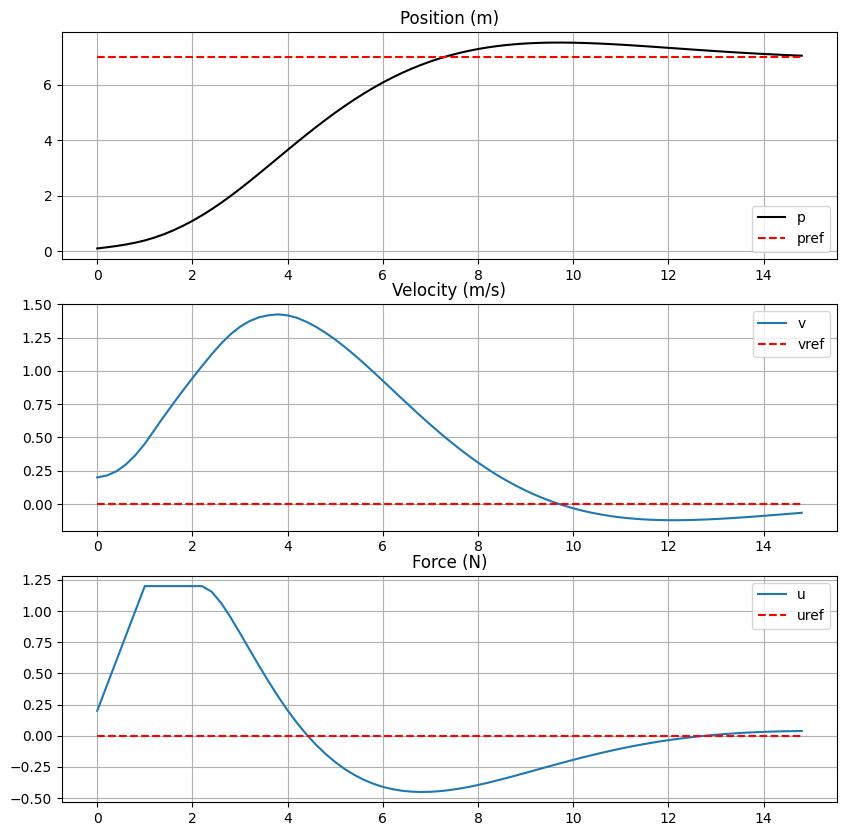

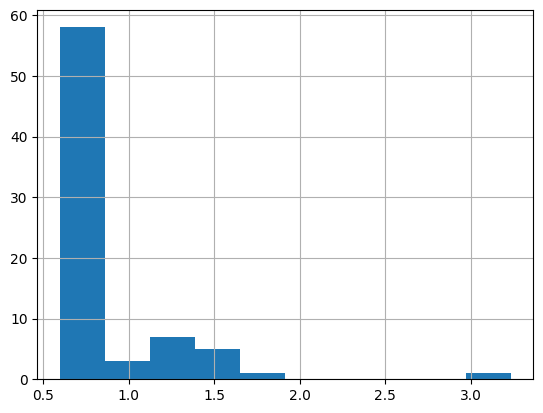

In [7]:
import numpy as np
import scipy.sparse as sparse
import time
import matplotlib.pyplot as plt
from pyMPC.mpc import MPCController
from scipy.integrate import ode


# Constants #
Ts = 0.2 # sampling time (s)
M = 2    # mass (Kg)
b = 0.3  # friction coefficient (N*s/m)

# Continuous-time matrices (just for reference)
Ac = np.array([
    [0.0, 1.0],
    [0, -b/M]]
)
Bc = np.array([
    [0.0],
    [1/M]
])

def f_ODE(t,x,u):
    der = Ac @ x + Bc @ u
    return der

[nx, nu] = Bc.shape  # number of states and number or inputs

# Simple forward euler discretization
Ad = np.eye(nx) + Ac*Ts
Bd = Bc*Ts


# Reference input and states
pref = 7.0
vref = 0.0
xref = np.array([pref, vref]) # reference state
uref = np.array([0.0])    # reference input
uminus1 = np.array([0.0])     # input at time step negative one - used to penalize the first delta u at time instant 0. Could be the same as uref.

# Constraints
xmin = np.array([-100.0, -100.0])
xmax = np.array([100.0,   100.0])

umin = np.array([-1.2])
umax = np.array([1.2])

Dumin = np.array([-2e-1])
Dumax = np.array([2e-1])

# Objective function
Qx = sparse.diags([0.5, 0.1])   # Quadratic cost for states x0, x1, ..., x_N-1
QxN = sparse.diags([0.5, 0.1])  # Quadratic cost for xN
Qu = 2.0 * sparse.eye(1)        # Quadratic cost for u0, u1, ...., u_N-1
QDu = 10.0 * sparse.eye(1)       # Quadratic cost for Du0, Du1, ...., Du_N-1

# Initial state
x0 = np.array([0.1, 0.2]) # initial state
system_dyn = ode(f_ODE).set_integrator('vode', method='bdf')
system_dyn.set_initial_value(x0, 0)
system_dyn.set_f_params(0.0)

# Prediction horizon
Np = 20

K = MPCController(Ad,Bd,Np=Np, x0=x0,xref=xref,uminus1=uminus1,
                  Qx=Qx, QxN=QxN, Qu=Qu,QDu=QDu,
                  xmin=xmin,xmax=xmax,umin=umin,umax=umax,Dumin=Dumin,Dumax=Dumax)
K.setup()

# Simulate in closed loop
[nx, nu] = Bd.shape # number of states and number or inputs
len_sim = 15 # simulation length (s)
nsim = int(len_sim/Ts) # simulation length(timesteps)
xsim = np.zeros((nsim,nx))
usim = np.zeros((nsim,nu))
tcalc = np.zeros((nsim,1))
tsim = np.arange(0,nsim)*Ts



xstep = x0
uMPC = uminus1

time_start = time.time()
for i in range(nsim):
    xsim[i,:] = xstep

    # MPC update and step. Could be in just one function call
    time_start = time.time()
    K.update(xstep, uMPC) # update with measurement
    uMPC = K.output() # MPC step (u_k value)
    tcalc[i,:] = time.time() - time_start
    usim[i,:] = uMPC

    #xstep = Ad.dot(xstep) + Bd.dot(uMPC)  # Real system step (x_k+1 value)
    system_dyn.set_f_params(uMPC) # set current input value to uMPC
    system_dyn.integrate(system_dyn.t + Ts)
    xstep = system_dyn.y


time_sim = time.time() - time_start
fig,axes = plt.subplots(3,1, figsize=(10,10))
axes[0].plot(tsim, xsim[:,0], "k", label='p')
axes[0].plot(tsim, xref[0]*np.ones(np.shape(tsim)), "r--", label="pref")
axes[0].set_title("Position (m)")

axes[1].plot(tsim, xsim[:,1], label="v")
axes[1].plot(tsim, xref[1]*np.ones(np.shape(tsim)), "r--", label="vref")
axes[1].set_title("Velocity (m/s)")

axes[2].plot(tsim, usim[:,0], label="u")
axes[2].plot(tsim, uref*np.ones(np.shape(tsim)), "r--", label="uref")
axes[2].set_title("Force (N)")

for ax in axes:
    ax.grid(True)
    ax.legend()

plt.figure()
plt.hist(tcalc*1000)
plt.grid(True)

<ipython-input-8-2b0972a2f707>:99: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  der[1] = (m*l*np.sin(theta)*omega**2 -m*g*np.sin(theta)*np.cos(theta)  + m*ftheta*np.cos(theta)*omega + F - b*v)/(M+m*(1-np.cos(theta)**2));
<ipython-input-8-2b0972a2f707>:101: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  der[3] = ((M+m)*(g*np.sin(theta) - ftheta*omega) - m*l*omega**2*np.sin(theta)*np.cos(theta) -(F-b*v)*np.cos(theta))/(l*(M + m*(1-np.cos(theta)**2)) );


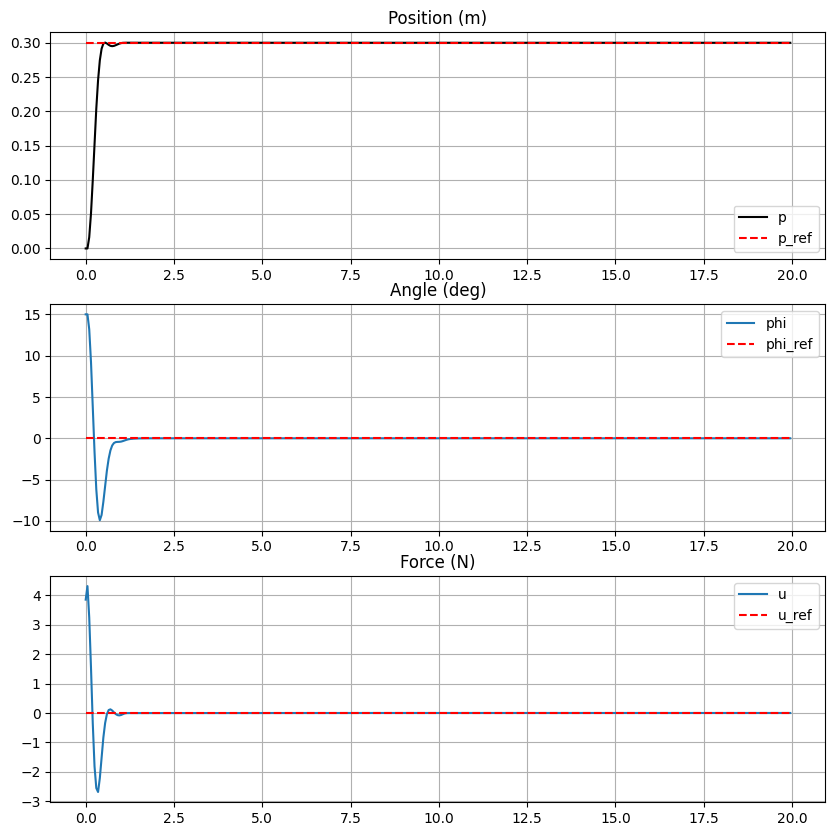

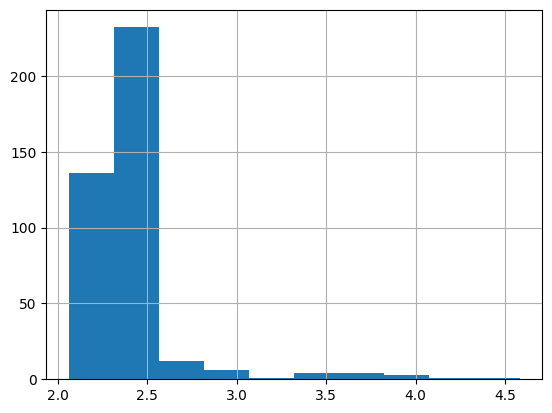

In [8]:
import numpy as np
import scipy.sparse as sparse
import time
import matplotlib.pyplot as plt
from pyMPC.mpc import MPCController


# Constants #
M = 0.5
m = 0.2
b = 0.1
ftheta = 0.1
l = 0.3
g = 9.81

Ts = 50e-3

Ac =np.array([[0,       1,          0,                  0],
              [0,       -b/M,       -(g*m)/M,           (ftheta*m)/M],
              [0,       0,          0,                  1],
              [0,       b/(M*l),    (M*g + g*m)/(M*l),  -(M*ftheta + ftheta*m)/(M*l)]])

Bc = np.array([
    [0.0],
    [1.0/M],
    [0.0],
    [-1/(M*l)]
])

[nx, nu] = Bc.shape # number of states and number or inputs

# Simple forward euler discretization
Ad = np.eye(nx) + Ac*Ts
Bd = Bc*Ts

# Reference input and states
xref = np.array([0.3, 0.0, 0.0, 0.0]) # reference state
uref = np.array([0.0])    # reference input
uminus1 = np.array([0.0])     # input at time step negative one - used to penalize the first delta u at time instant 0. Could be the same as uref.

# Constraints
xmin = np.array([-1.0, -100, -100, -100])
xmax = np.array([0.3,   100.0, 100, 100])

umin = np.array([-20])
umax = np.array([20])

Dumin = np.array([-5])
Dumax = np.array([5])

# Objective function weights
Qx = sparse.diags([0.3, 0, 1.0, 0])   # Quadratic cost for states x0, x1, ..., x_N-1
QxN = sparse.diags([0.3, 0, 1.0, 0])  # Quadratic cost for xN
Qu = 0.0 * sparse.eye(1)        # Quadratic cost for u0, u1, ...., u_N-1
QDu = 0.01 * sparse.eye(1)       # Quadratic cost for Du0, Du1, ...., Du_N-1

# Initial state
phi0 = 15*2*np.pi/360
x0 = np.array([0, 0, phi0, 0]) # initial state

# Prediction horizon
Np = 20

K = MPCController(Ad,Bd,Np=Np, x0=x0,xref=xref,uminus1=uminus1,
                  Qx=Qx, QxN=QxN, Qu=Qu,QDu=QDu,
                  xmin=xmin,xmax=xmax,umin=umin,umax=umax,Dumin=Dumin,Dumax=Dumax,
                  eps_feas=1e3)
K.setup()

# Simulate in closed loop
[nx, nu] = Bd.shape # number of states and number or inputs
len_sim = 20 # simulation length (s)
nsim = int(len_sim/Ts) # simulation length(timesteps)
xsim = np.zeros((nsim,nx))
tcalc = np.zeros((nsim,1))
usim = np.zeros((nsim,nu))
tsim = np.arange(0,nsim)*Ts

time_start = time.time()

xstep = x0
uMPC =  uminus1
for i in range(nsim):
    xsim[i,:] = xstep

    # MPC update and step. Could be in just one function call
    time_start = time.time()
    K.update(xstep, uMPC) # update with measurement
    uMPC = K.output() # MPC step (u_k value)
    tcalc[i,:] = time.time() - time_start
    usim[i,:] = uMPC
    # System simulation step
    F = uMPC
    v = xstep[1]
    theta = xstep[2]
    omega = xstep[3]
    der = np.zeros(nx)
    der[0] = v
    der[1] = (m*l*np.sin(theta)*omega**2 -m*g*np.sin(theta)*np.cos(theta)  + m*ftheta*np.cos(theta)*omega + F - b*v)/(M+m*(1-np.cos(theta)**2));
    der[2] = omega
    der[3] = ((M+m)*(g*np.sin(theta) - ftheta*omega) - m*l*omega**2*np.sin(theta)*np.cos(theta) -(F-b*v)*np.cos(theta))/(l*(M + m*(1-np.cos(theta)**2)) );
    # Forward euler step
    xstep = xstep + der*Ts

time_sim = time.time() - time_start

fig,axes = plt.subplots(3, 1, figsize=(10, 10))
axes[0].plot(tsim, xsim[:, 0], "k", label='p')
axes[0].plot(tsim, xref[0]*np.ones(np.shape(tsim)), "r--", label="p_ref")
axes[0].set_title("Position (m)")

axes[1].plot(tsim, xsim[:, 2]*360/2/np.pi, label="phi")
axes[1].plot(tsim, xref[2]*360/2/np.pi*np.ones(np.shape(tsim)), "r--", label="phi_ref")
axes[1].set_title("Angle (deg)")

axes[2].plot(tsim, usim[:, 0], label="u")
axes[2].plot(tsim, uref*np.ones(np.shape(tsim)), "r--", label="u_ref")
axes[2].set_title("Force (N)")

for ax in axes:
    ax.grid(True)
    ax.legend()

plt.figure()
plt.hist(tcalc*1000)
plt.grid(True)